In [1]:
import pandas as pd
import os
from ast import literal_eval

pd.set_option('display.max_columns', None)
os.chdir(r"C:\Users\LMENENDEZ\GitHub\MultiModX")
print(os.getcwd())

C:\Users\LMENENDEZ\GitHub\MultiModX


In [2]:
%load_ext autoreload

In [35]:
%autoreload
from script.trips_format import *
from strategic_evaluator.logit_model import *

In [4]:
pre_calibration_matrix=pd.read_csv(r".\pre_calibration_matrix_CS11.csv")

In [5]:
pre_calibration_matrix.head()

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air,cost_ground,total_time_ground,emissions_ground,number_of_options_per_od
0,ES111,BRUSSELS,access,"['LEST', 'BRUSSELS']",43.0,50.443667,134.69,1559.5,1,104,0.0,53.0,0.0,2
1,ES111,BRUSSELS,access,"['LEST', 'LEMD', 'BRUSSELS']",11.0,12.087667,134.69,1559.5,2,224,0.0,53.0,0.0,2
2,ES111,EDDM,access,"['LEST', 'EDDM']",15.0,15.474000,213.24,1830.0,1,122,0.0,53.0,0.0,2
3,ES111,EDDM,access,"['LEST', 'LEMD', 'EDDM']",10.0,12.387667,213.24,1830.0,2,242,0.0,53.0,0.0,2
4,ES111,EHAM,access,"['LEST', 'EHAM']",46.0,50.568667,180.87,1691.0,1,113,0.0,53.0,0.0,4


In [6]:
pre_calibration_matrix[pre_calibration_matrix["number_of_options_per_od"]<=3]["trips"].sum()

np.float64(148223.0)

In [7]:
pre_calibration_matrix[pre_calibration_matrix["number_of_options_per_od"]>3]["trips"].sum()

np.float64(11485.0)

Since most trips have 3 options or less, I will stay with only these

In [8]:
pre_calibration_matrix.columns

Index(['origin', 'destination', 'node_sequence_ground', 'node_sequence_air',
       'trips', 'trips_air', 'cost_air', 'distance_air', 'option_number',
       'total_time_air', 'cost_ground', 'total_time_ground',
       'emissions_ground', 'number_of_options_per_od'],
      dtype='object')

In [9]:
pre_calibration_matrix

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air,cost_ground,total_time_ground,emissions_ground,number_of_options_per_od
0,ES111,BRUSSELS,access,"['LEST', 'BRUSSELS']",43.0,50.443667,134.690000,1559.500000,1,104,0.00,53.0,0.00,2
1,ES111,BRUSSELS,access,"['LEST', 'LEMD', 'BRUSSELS']",11.0,12.087667,134.690000,1559.500000,2,224,0.00,53.0,0.00,2
2,ES111,EDDM,access,"['LEST', 'EDDM']",15.0,15.474000,213.240000,1830.000000,1,122,0.00,53.0,0.00,2
3,ES111,EDDM,access,"['LEST', 'LEMD', 'EDDM']",10.0,12.387667,213.240000,1830.000000,2,242,0.00,53.0,0.00,2
4,ES111,EHAM,access,"['LEST', 'EHAM']",46.0,50.568667,180.870000,1691.000000,1,113,0.00,53.0,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,ES211,LPPR,access,"['LEBB', 'LPPR']",3.0,103.099000,82.390000,761.666667,1,51,0.00,56.0,0.00,2
2383,ES211,LPPR,access,"['LEBB', 'LEMD', 'LPPR']",1.0,10.867000,82.390000,761.666667,2,171,0.00,56.0,0.00,2
2384,ES211,MILAN,access,"['LEVT', 'MILAN']",22.0,50.721000,87.600000,1035.000000,1,69,0.00,16.0,0.00,3
2385,ES211,MILAN,access,"['LEBB', 'MILAN']",12.0,130.718667,108.410000,959.000000,2,64,0.00,56.0,0.00,3


In [10]:
def preformat_trips_logit(trips):
    # calculate quantities that will be used for calibration
    trips["total_travel_time"]=trips["total_time_air"]+trips["total_time_ground"]
    trips["total_cost"]=trips["cost_air"]+trips["cost_ground"]
    trips["total_emissions"]=trips["emissions_ground"] #ADD EMISSIONS AIR WHEN I HAVE THEM
    
    # construct path for trips whose node_sequence_ground is only access or egress
    trips.loc[trips["node_sequence_ground"].isin(["access","egress"]),"path"]=trips["node_sequence_air"]

    # filter for trips leaving spain and having non-trivial ground sequence
    filter_leaving=~(trips["node_sequence_ground"].isin(["access","egress"]))& trips["origin"].str.startswith("ES") & trips["origin"].str[2].str.isdigit()
    trips.loc[filter_leaving,"path_list"]=trips.loc[filter_leaving,"node_sequence_ground"].apply(ast.literal_eval) + trips.loc[filter_leaving,"node_sequence_air"].apply(ast.literal_eval)
    
    # filter for trips incoming with non-trivial ground sequence
    filter_incoming=~(trips["node_sequence_ground"].isin(["access","egress"]))& trips["destination"].str.startswith("ES") & trips["destination"].str[2].str.isdigit()
    trips.loc[filter_incoming,"path_list"]=trips.loc[filter_incoming,"node_sequence_air"].apply(ast.literal_eval) + trips.loc[filter_incoming,"node_sequence_ground"].apply(ast.literal_eval)

    # filter all trips with only access or egress as ground sequence
    condition=~(trips["node_sequence_ground"].isin(["access", "egress"]))
    trips.loc[condition, "path"] = trips.loc[condition,"path_list"].apply(str)
    
    #drop useless columns
    trips=trips.drop(columns=["trips_air","option_number","number_of_options_per_od","total_time_ground","total_time_air","emissions_ground","cost_air","cost_ground","distance_air","node_sequence_ground","node_sequence_air","path_list"])
    return trips

In [11]:
trips_logit=preformat_trips_logit(pre_calibration_matrix)

In [12]:
trips_logit.sample(5)

,origin,destination,trips,total_travel_time,total_cost,total_emissions,path
1626,MILAN,ES130,30.0,90.000000,88.360000,0.00,"['MILAN', 'LEXJ']"
1371,LIRN,ES612,3.0,287.000000,38.700000,0.00,"['LIRN', 'LEMG']"
1698,ES300,KMIA,1.0,775.172414,419.090000,14.56,"['007160000', '007171801', 'LEBL', 'KMIA']"
1670,MOSCOW,ES511,5.0,348.410256,123.223677,2.53,"['MOSCOW', 'LEGE', '007179300', '007171801']"
1402,LKPR,ES514,20.0,167.000000,106.500000,0.00,"['LKPR', 'LEBL']"


In [13]:
trips_logit[trips_logit["path"].notna()]

,origin,destination,trips,total_travel_time,total_cost,total_emissions,path
0,ES111,BRUSSELS,43.0,157.0,134.690000,0.00,"['LEST', 'BRUSSELS']"
1,ES111,BRUSSELS,11.0,277.0,134.690000,0.00,"['LEST', 'LEMD', 'BRUSSELS']"
2,ES111,EDDM,15.0,175.0,213.240000,0.00,"['LEST', 'EDDM']"
3,ES111,EDDM,10.0,295.0,213.240000,0.00,"['LEST', 'LEMD', 'EDDM']"
4,ES111,EHAM,46.0,166.0,180.870000,0.00,"['LEST', 'EHAM']"
...,...,...,...,...,...,...,...
2382,ES211,LPPR,3.0,107.0,82.390000,0.00,"['LEBB', 'LPPR']"
2383,ES211,LPPR,1.0,227.0,82.390000,0.00,"['LEBB', 'LEMD', 'LPPR']"
2384,ES211,MILAN,22.0,85.0,87.600000,0.00,"['LEVT', 'MILAN']"
2385,ES211,MILAN,12.0,120.0,108.410000,0.00,"['LEBB', 'MILAN']"


In [14]:
trips_logit[trips_logit["path"].isna()]

,origin,destination,trips,total_travel_time,total_cost,total_emissions,path


In [15]:
trips_logit_formatted=trips_logit_format(trips_logit=trips_logit,
                                         max_num_options=3,
                                         drop_single_paths=True,
                                         n_archetypes=1
                                         )

In [16]:
trips_logit_formatted

,origin,destination,trips,total_travel_time,total_cost,total_emissions,path,noption,trips_per_od_pair,prob_per_od_pair_arch_0
0,BELFAST,ES511,112.0,140.000000,94.390000,0.00,"['BELFAST', 'LEBL']",1,120.0,0.933333
1,BELFAST,ES511,8.0,258.410256,101.950000,2.53,"['BELFAST', 'LEGE', '007179300', '007171801']",2,120.0,0.066667
2,BELFAST,ES512,40.0,130.000000,93.870000,0.00,"['BELFAST', 'LEGE']",1,44.0,0.909091
3,BELFAST,ES512,4.0,198.000000,94.390000,0.00,"['BELFAST', 'LEBL']",2,44.0,0.090909
4,BELFAST,ES514,66.0,138.000000,101.240000,0.00,"['BELFAST', 'LERS']",1,68.0,0.970588
...,...,...,...,...,...,...,...,...,...,...
2382,VENICE,ES612,5.0,234.000000,45.385712,0.00,"['VENICE', 'LEZL']",1,10.0,0.500000
2383,VENICE,ES612,4.0,320.666667,55.085712,3.04,"['VENICE', 'LEZL', '007151003', '007151406']",2,10.0,0.400000
2384,VENICE,ES612,1.0,290.000000,60.643029,0.00,"['VENICE', 'LEMG']",3,10.0,0.100000
2385,VENICE,ES613,2.0,235.000000,45.385712,0.00,"['VENICE', 'LEZL']",1,3.0,0.666667


In [17]:
paths_w_costs=generate_paths_w_costs(trips_logit=trips_logit_formatted,
                                     max_num_option=3
                                     )

In [18]:
paths_w_costs.sample(5)

,origin,destination,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3
1838,LIEE,ES514,118.0,68.480000,0.0,0,1,0,1,295.230769,81.970000,4.22,0,0,1,1,218.057143,75.88,2.32,0,0,1,1
772,ES431,PARIS,355.0,128.246657,0.0,0,1,0,1,245.000000,123.435738,0.00,0,1,0,1,-1.000000,-1.00,-1.00,0,0,0,0
2050,LSGG,ES514,118.0,83.080000,0.0,0,1,0,1,295.230769,96.570000,4.22,0,0,1,1,-1.000000,-1.00,-1.00,0,0,0,0
1622,FRANKFURT,ES220,97.0,205.310000,0.0,0,1,0,1,212.000000,214.480000,0.00,0,1,0,1,-1.000000,-1.00,-1.00,0,0,0,0
1367,ES613,EGPH,284.0,65.370000,0.0,0,1,0,1,257.000000,68.400000,0.00,0,1,0,1,-1.000000,-1.00,-1.00,0,0,0,0


In [19]:
trips_logit_formatted[(trips_logit_formatted["origin"]=="ES521")&(trips_logit_formatted["destination"]=="BELFAST")]

,origin,destination,trips,total_travel_time,total_cost,total_emissions,path,noption,trips_per_od_pair,prob_per_od_pair_arch_0
1061,ES521,BELFAST,431.0,164.0,96.48,0.0,"['LEAL', 'BELFAST']",1,437.0,0.98627
1062,ES521,BELFAST,6.0,260.0,94.20,0.0,"['LEVC', 'BELFAST']",2,437.0,0.01373


In [20]:
trips_logit_formatted[(trips_logit_formatted["origin"]=="EGGD")&(trips_logit_formatted["destination"]=="ES514")]

,origin,destination,trips,total_travel_time,total_cost,total_emissions,path,noption,trips_per_od_pair,prob_per_od_pair_arch_0
229,EGGD,ES514,24.0,109.000000,89.28,0.00,"['EGGD', 'LERS']",1,37.0,0.648649
230,EGGD,ES514,12.0,155.000000,88.34,0.00,"['EGGD', 'LEBL']",2,37.0,0.324324
231,EGGD,ES514,1.0,332.230769,101.83,4.22,"['EGGD', 'LEBL', '007171801', '007165402']",3,37.0,0.027027


In [21]:
calibration_matrix=generate_calibration_matrix(trips_logit=trips_logit_formatted,
                            paths_w_costs=paths_w_costs,
                            drop_single_paths=True)

In [22]:
calibration_matrix.columns

Index(['trips', 'total_travel_time', 'observed_choice', 'travel_time_1',
       'cost_1', 'emissions_1', 'train_1', 'plane_1', 'multimodal_1', 'av_1',
       'travel_time_2', 'cost_2', 'emissions_2', 'train_2', 'plane_2',
       'multimodal_2', 'av_2', 'travel_time_3', 'cost_3', 'emissions_3',
       'train_3', 'plane_3', 'multimodal_3', 'av_3'],
      dtype='object')

In [23]:
calibration_matrix[calibration_matrix["train_1"]!=0]

,trips,total_travel_time,observed_choice,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3


In [24]:
calibration_matrix[calibration_matrix["train_2"]!=0]

,trips,total_travel_time,observed_choice,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3


In [25]:
calibration_matrix[calibration_matrix["train_3"]!=0]

,trips,total_travel_time,observed_choice,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3


In this case, there are no trips with rail. So we have to change the way we calibrate the model, perhaps using a dictionary?

In [26]:
calibration_matrix.columns

Index(['trips', 'total_travel_time', 'observed_choice', 'travel_time_1',
       'cost_1', 'emissions_1', 'train_1', 'plane_1', 'multimodal_1', 'av_1',
       'travel_time_2', 'cost_2', 'emissions_2', 'train_2', 'plane_2',
       'multimodal_2', 'av_2', 'travel_time_3', 'cost_3', 'emissions_3',
       'train_3', 'plane_3', 'multimodal_3', 'av_3'],
      dtype='object')

In [27]:
calibration_matrix.to_csv("calibration_matrix_CS11_v0.1.csv")

In [28]:
# Delete pickle files if they already exist 
pickle_file="trips.pickle"
if os.path.exists(pickle_file):
    os.remove(pickle_file)
    print(f"Deleted {pickle_file}")
else: 
    print(f"pickle file {pickle_file} doesn't exist")


Deleted trips.pickle


In [29]:
database_path=r".\calibration_matrix_CS11_v0.1.csv"
test_results=calibrate_main(database_path=database_path,
                            n_archetypes=1,
                            n_alternatives=3)

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-5[3.0]-8[3.0]-10[3.0]-13[3.0]-14[3.0]-15[3.0]-16[3.0]-17[3.0]-19[3.0]-23...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-5[3.0]-8[3.0]-10[3.0]-13[3.0]-14[3.0]-15[3.0]-16[3.0]-17[3.0]-19[3.0]-23...


Training results:
Results for model trips
Nbr of parameters:		4
Sample size:			1880
Excluded data:			0
Final log likelihood:		-369.9086
Akaike Information Criterion:	747.8172
Bayesian Information Criterion:	769.9733

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.318526  3.028712e-01     4.353421      0.000013
ASC_TRAIN  0.000000  1.616093e-15     0.000000      1.000000
B_COST    -0.000728  2.666375e-03    -0.273041      0.784822
B_TIME    -0.021958  1.351074e-03   -16.252210      0.000000
{'ASC_PLANE': np.float64(1.318525657860279), 'ASC_TRAIN': np.float64(0.0), 'B_COST': np.float64(-0.0007280299346942433), 'B_TIME': np.float64(-0.021957943972569866)}
Test results:
{'ASC_PLANE': np.float64(1.318525657860279), 'ASC_TRAIN': np.float64(0.0), 'B_COST': np.float64(-0.0007280299346942433), 'B_TIME': np.float64(-0.021957943972569866)}
        prob_1    prob_2    prob_3
910   0.942924  0.057076  0.000000
453   0.132637  0.867363  0.000000
1960  0.933078  0.066922  0

In [30]:
test_results

{'test_results':         prob_1    prob_2    prob_3
 910   0.942924  0.057076  0.000000
 453   0.132637  0.867363  0.000000
 1960  0.933078  0.066922  0.000000
 243   0.376878  0.623122  0.000000
 195   0.879818  0.116228  0.003954
 ...        ...       ...       ...
 1441  0.999114  0.000886  0.000000
 1252  0.900951  0.099049  0.000000
 1408  0.013231  0.986769  0.000000
 1078  0.891564  0.108436  0.000000
 2289  0.933078  0.066922  0.000000
 
 [470 rows x 3 columns]}

In [31]:
archetypes={}
archetypes["archetype_0"]=res.bioResults(pickle_file="trips.pickle")

In [32]:
def calibration_results_summary_one_arch(archetypes: dict):
    data=[]
    
    archetype = archetypes["archetype_0"] # accesses the values  
    values=archetype.get_estimated_parameters() # dataframe of the betavalues 
    
    asc_plane = values.loc['ASC_PLANE']["Value"]  
    asc_plane_significance=(values.loc["ASC_PLANE"]["Rob. p-value"]<0.05)

    #asc_train = values.loc['ASC_TRAIN']["Value"]
    #asc_train_significance=(values.loc["ASC_TRAIN"]["Rob. p-value"]<0.05)

    #b_co2 = values.loc['B_CO2']["Value"]      
    #b_co2_significance=(values.loc["B_CO2"]["Rob. p-value"]<0.05)

    b_time = values.loc['B_TIME']["Value"]
    b_time_significance=(values.loc["B_TIME"]["Rob. p-value"]<0.05)

    b_cost=values.loc["B_COST"]["Value"]
    b_cost_significance=(values.loc["B_COST"]["Rob. p-value"]<0.05)

    # Create a row dictionary
    row = {
        "Archetype": "Archetype_0",
        "ASC_PLANE": asc_plane,
        "ASC_PLANE_SIGNIFICANCE": asc_plane_significance,
        #"ASC_TRAIN": asc_train,
        #"ASC_TRAIN_SIGNIFICANCE": asc_train_significance,
        #"B_CO2": b_co2,
        #"B_CO2_SIGNIFICANCE": b_co2_significance,
        "B_TIME": b_time,
        "B_TIME_SIGNIFICANCE": b_time_significance,
        "B_COST": b_cost,
        "B_COST_SIGNIFICANCE": b_cost_significance
    }
    
    # Append the row to the list
    data.append(row)

    calibration_results = pd.DataFrame(data)
    return calibration_results

In [33]:
calibration_results_summary_one_arch(archetypes=archetypes)

,Archetype,ASC_PLANE,ASC_PLANE_SIGNIFICANCE,B_TIME,B_TIME_SIGNIFICANCE,B_COST,B_COST_SIGNIFICANCE
0,Archetype_0,1.318526,True,-0.021958,True,-0.000728,False


In [36]:
final_test=test_logit(test_results,trips_logit_formatted, n_alternatives=1)

in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the making
in the

In [37]:
final_test

{'archetype_0':      location prob_predicted prob_observed
 0         910       0.057076      0.090909
 1         453       0.867363           0.5
 2        1960       0.066922      0.096154
 3         243       0.376878           0.5
 4         195       0.116228      0.004878
 ..        ...            ...           ...
 465      1441       0.000886      0.006849
 466      1252       0.900951       0.93299
 467      1408       0.013231           0.5
 468      1078       0.891564      0.970588
 469      2289       0.933078          0.75
 
 [470 rows x 3 columns]}

In [40]:
evaluate_model(test_data=final_test["archetype_0"],model_name="international")

international Evaluation:
Mean Squared Error: 0.0424
Mean Absolute Error: 0.1402
Pearson Correlation: 0.8574
Spearman Correlation: 0.8603
Standard deviation: 0.2057


(np.float64(0.04238437962489687),
 np.float64(0.14015346678359195),
 np.float64(0.8573894618829209),
 np.float64(0.8602731756148501),
 np.float64(0.20569771317301863))

0 rows were removed


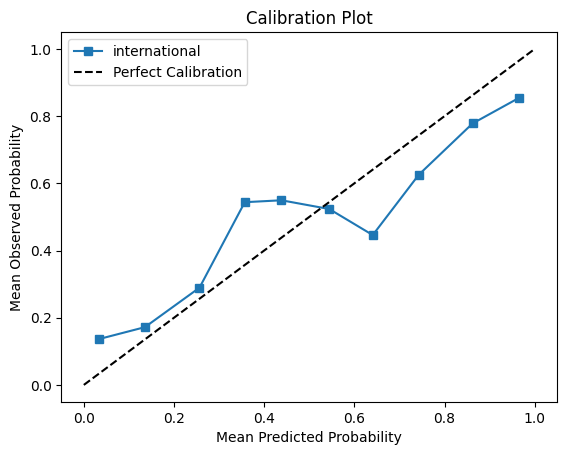

In [42]:
calibration_plot(test_data=final_test["archetype_0"],model_name="international")